### Import Libraries

In [ ]:
pip install imbalanced-learn transformers torch scikit-learn

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import joblib

### Read the test and train dataset from the checkpoint

In [90]:
train_df = pd.read_csv("../data/train_dataset_w56types.csv")

In [91]:
train_df.shape

(7220, 11)

## Data Preprocessing

In [92]:
# Get unique count of values in each column
unique_counts = train_df.apply(lambda x: x.nunique())
print("\nUnique Value Counts:")
print(unique_counts)


Unique Value Counts:
project_id                                7220
project_name                              7155
methodologyorprotocol                      286
fully_harmonized_methodologyorprotocol     271
region                                       8
voluntary_registry                           4
type_from_registry                          96
project_developer                         2503
arborwa_project                              3
type                                        56
rule-based_type_mapping_first               48
dtype: int64


### SMOTE to handle Data Imbalance of minority classes

## Identify the outliers from projectTypes

In [93]:

type_df = train_df["type"]
type_counts = type_df.value_counts().reset_index()
type_counts.columns = ["type", 'count']

type_counts


,type,count
0,Cookstoves,1147
1,Wind,811
2,Improved Forest Management,605
3,Hydropower,423
4,Afforestation/Reforestation,378
5,Manure Methane Digester,359
6,Clean Water,330
7,Landfill Methane,306
8,Solar - Centralized,258
9,Ozone Depleting Substances Recovery & Destruction,234


In [295]:
# Based on the Zscore, the major classes will be undersampled and minority classes will be oversample

In [94]:
X_train_df = train_df.drop(columns=['type'])
Y_train_df = train_df['type']

In [58]:
print(X_train_df.shape)

(7222, 11)


In [95]:
## Splitting the train to train and validation sets
X_train_1, X_val_1, Y_train, Y_val  = train_test_split(X_train_df,Y_train_df, test_size=0.1, stratify =Y_train_df,  random_state=42)
print(X_train_1.shape, X_val_1.shape, Y_train.shape, Y_val.shape )

(6498, 10) (722, 10) (6498,) (722,)


In [96]:
X_train = X_train_1.drop(columns=['project_id','rule-based_type_mapping_first', 'methodologyorprotocol'])
X_val = X_val_1.drop(columns=['project_id','rule-based_type_mapping_first', 'methodologyorprotocol'])


## Encoding the categorical and text features


In [97]:
# Define categorical and text features
categorical_features = ['region', 'voluntary_registry', 'arborwa_project']
text_features = ['project_name','fully_harmonized_methodologyorprotocol','type_from_registry', 'project_developer']

In [98]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for text features
text_transformers = [(f'text_{i}', TfidfVectorizer(), col) for i, col in enumerate(text_features)]

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ] + text_transformers,
    remainder='passthrough'
)

# Define SMOTE and RandomUnderSampler
over_sampling = RandomOverSampler(random_state=42)
sampling_strategy = {
    'Cookstoves': 800
}
under_sampling = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

# Pipeline for preprocessing and resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampling', under_sampling),
    ('oversampling', over_sampling)
])

# Apply preprocessing, SMOTE, and undersampling
X_resampled_combined, y_resampled = pipeline.fit_resample(X_train, Y_train)


In [99]:
print(X_resampled_combined.shape, y_resampled.shape)
print(X_resampled_combined.dtype)

(44800, 11539) (44800,)
float64


In [100]:
# Check the class distribution after resampling
resampledCounter = Counter(y_resampled)
originalCounter = Counter(Y_train_df)

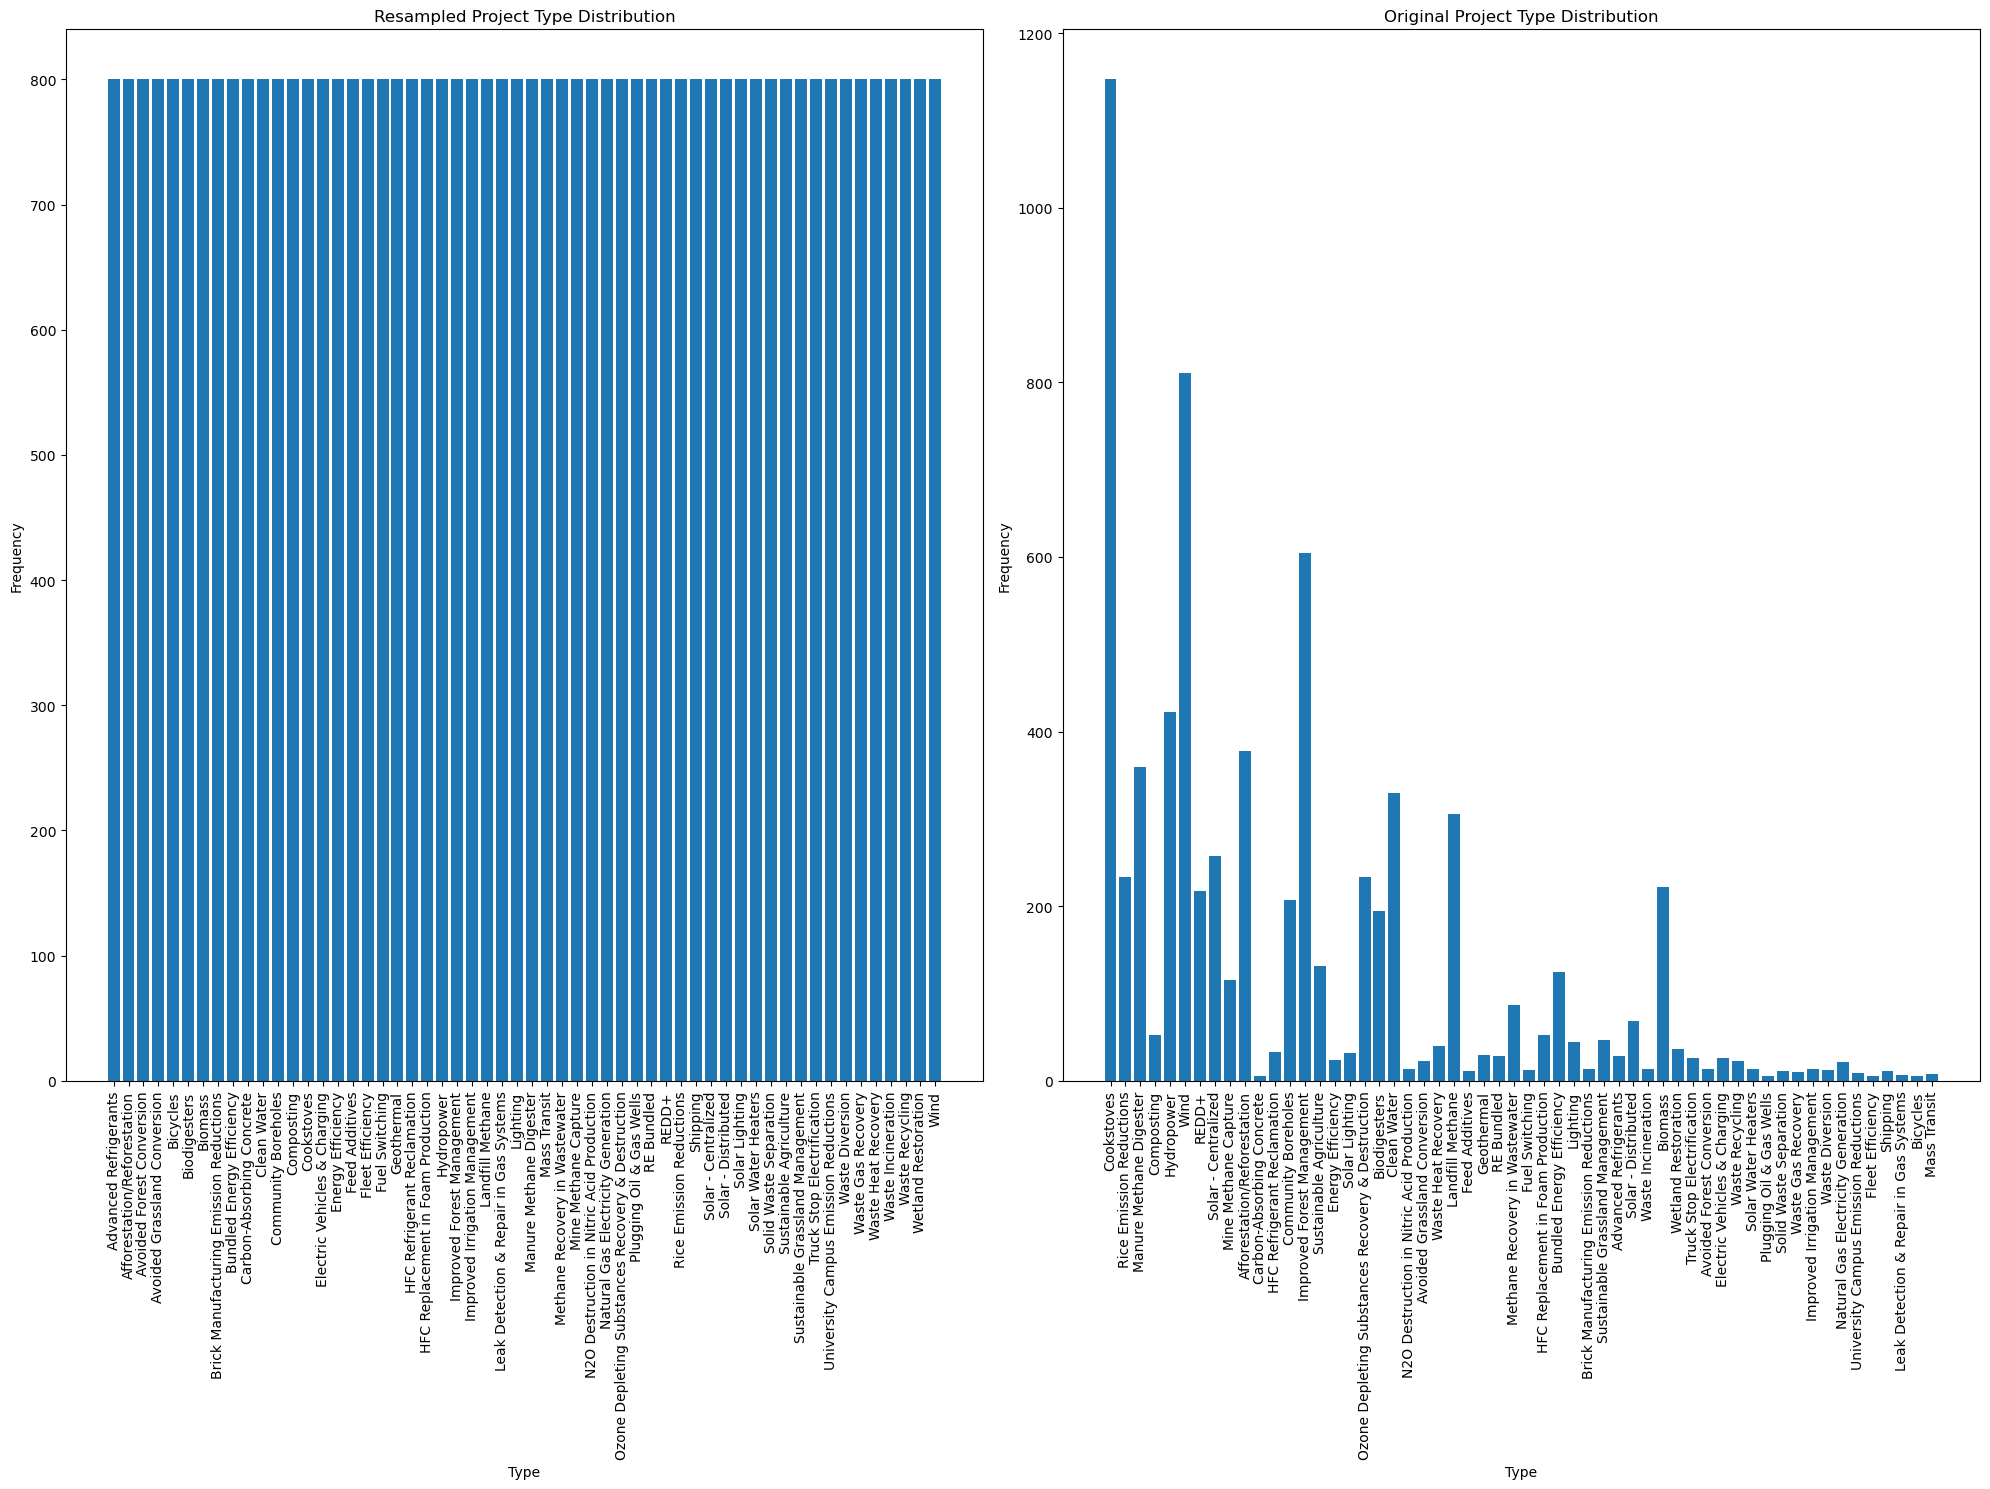

In [101]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# Resampled class distribution histogram
axes[0].bar(resampledCounter.keys(), resampledCounter.values())
axes[0].set_title('Resampled Project Type Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(list(resampledCounter.keys()))
axes[0].set_xticklabels(resampledCounter.keys(), rotation=90)

# Original class distribution histogram
axes[1].bar(originalCounter.keys(), originalCounter.values())
axes[1].set_title('Original Project Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(list(originalCounter.keys()))
axes[1].set_xticklabels(originalCounter.keys(), rotation=90)

# Display the histograms
plt.tight_layout()
plt.show()


### Logistic Regression

In [102]:
# Define the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the logistic regression model on the resampled data
logistic_regression.fit(X_resampled_combined, y_resampled)



LogisticRegression(max_iter=1000, random_state=42)

In [105]:
## Save the model and processor with Joblib

joblib.dump(preprocessor, '../data/models/tfidf_onehotencoding_56types.pkl')

# Save the Logistic Regression model
joblib.dump(logistic_regression, '../data/models/logistic_regression_model_56types.pkl')

['../data/models/logistic_regression_model_56types.pkl']

In [106]:
# Make predictions on the val data

X_val_transformed = preprocessor.transform(X_val)
y_pred = logistic_regression.predict(X_val_transformed)

# Get the predicted probabilities for each class
y_pred_proba = logistic_regression.predict_proba(X_val_transformed)
# Evaluate the model and get the classification report
report = classification_report(Y_val, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df = pd.DataFrame(report).transpose()

# Display the classification report table
report_df

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,3.000000
Afforestation/Reforestation,1.000000,0.973684,0.986667,38.000000
Avoided Forest Conversion,0.000000,0.000000,0.000000,1.000000
Avoided Grassland Conversion,0.666667,1.000000,0.800000,2.000000
Bicycles,0.000000,0.000000,0.000000,1.000000
Biodigesters,0.950000,1.000000,0.974359,19.000000
Biomass,0.954545,0.954545,0.954545,22.000000
Brick Manufacturing Emission Reductions,1.000000,1.000000,1.000000,1.000000
Bundled Energy Efficiency,0.888889,0.666667,0.761905,12.000000
Carbon-Absorbing Concrete,1.000000,1.000000,1.000000,1.000000


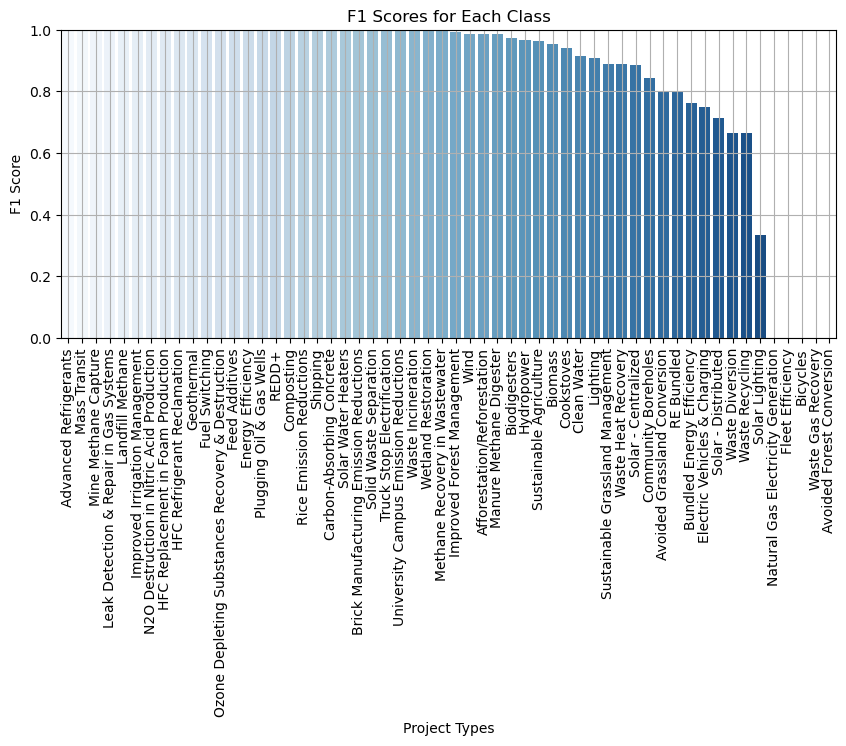

In [107]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(10, 4))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Each Class')
plt.xlabel('Project Types')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.grid(True)
plt.show()

In [26]:
## Check all the incorrect predictions

In [110]:
# Create a DataFrame to compare true labels and predictions
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})

# Extract the dropped feature from the original X_test
dropped_feature_project_id = X_val_1['project_id'].reset_index(drop=True)
dropped_feature_rbtype = X_val_1['rule-based_type_mapping_first'].reset_index(drop=True)
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id
comparison_df['rule-based_type_mapping_first'] = dropped_feature_rbtype
# Display the DataFrame with incorrect predictions
incorrect_predictions = comparison_df[~comparison_df['Correct Prediction']]
print(incorrect_predictions.shape)
incorrect_predictions

(36, 13)


,project_name,fully_harmonized_methodologyorprotocol,region,voluntary_registry,type_from_registry,project_developer,arborwa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id,rule-based_type_mapping_first
2,GS11955 PoA Safe Water Supply in South Africa,GS TPDDTEC Reduced emissions from cooking and ...,,GOLD,Energy Efficiency - Domestic,Offset Financial Holdings LLC,No,Bundled Energy Efficiency,Clean Water,0.638433,False,GS11955,
21,"Guadalupe Zajú, Chanjul, San Antonio Chicharras",CAR Mexico Forest Protocol,,CAR,Forestry - MX,Toroto SAPI de CV,No,Afforestation/Reforestation,Improved Forest Management,0.921981,False,CAR1484,Improved Forest Management
55,Energy-efficient biomass cook stoves and bioma...,AMS-I.C. Thermal energy production with or wit...,,GOLD,"Biomass, or Liquid Biofuel - Heat",myclimate Foundation,No,Cookstoves,Biomass,0.964978,False,GS1062,Biomass
59,GS1247 VPA 12 Improved Kitchen Regimes: Shyara...,GS TPDDTEC Reduced emissions from cooking and ...,,GOLD,Energy Efficiency - Domestic,CO2balance UK ltd,No,Cookstoves,Community Boreholes,0.771404,False,GS3444,
61,Socially Responsible Plastic Waste Collection ...,AMS-III.J. Avoidance of fossil fuel combustion...,Asia,VCS,Manufacturing industries; Waste handling and d...,Gemcorp Recycling & Technologies Private Limited,No,Waste Recycling,Waste Diversion,0.247941,False,VCS4093,
95,GS1247 VPA 149 Southern Ethiopia Community Saf...,GS TPDDTEC Reduced emissions from cooking and ...,,GOLD,Energy Efficiency - Domestic,CO2balance UK ltd,No,Community Boreholes,Clean Water,0.692183,False,GS6783,
134,Solar Power for Rural Villages in Madagascar,AMS-I.L. Electrification of rural communities ...,,GOLD,Solar Thermal - Electricity,Tsanta Rabekoto,No,Solar - Distributed,Solar Lighting,0.704653,False,GS12379,
150,MOTOR VEHICLE REPLACEMENT WITH UTILITY E-BIKE,AMS-III.C. Emission reductions by electric and...,Asia,VCS,Transport,MOOV TECHNOLOGY (S) PTE. LTD.,No,Bicycles,Electric Vehicles & Charging,0.955357,False,VCS3029,
158,GS7591 VPA 55 Clean Cooking in Nigeria,GS TPDDTEC Reduced emissions from cooking and ...,,GOLD,Energy Efficiency - Domestic,CO2balance UK ltd,No,Cookstoves,Clean Water,0.447476,False,GS12304,
159,One True Measure (Pty) Ltd Solar PV Grouped Pr...,AMS-II.F. Energy efficiency and fuel switching...,Africa,VCS,Energy industries (renewable/non-renewable sou...,One True Measure (Pty) Ltd,No,Solar - Centralized,Solar - Distributed,0.550929,False,VCS1545,


In [29]:
## Confidence level of the result

In [112]:
# Create a DataFrame to compare true labels and predictions with confidence levels
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})
# Extract the dropped feature from the original X_test
dropped_feature_project_id = X_val_1['project_id'].reset_index(drop=True)
dropped_feature_rbtype = X_val_1['rule-based_type_mapping_first'].reset_index(drop=True)
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id
comparison_df['rule-based_type_mapping_first'] = dropped_feature_rbtype

correct_predictions = comparison_df[comparison_df['Correct Prediction']]
correct_predictions

,project_name,fully_harmonized_methodologyorprotocol,region,voluntary_registry,type_from_registry,project_developer,arborwa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id,rule-based_type_mapping_first
0,Karaman Biomass-to-Energy Facility Turkey,AMS-I.D. Grid connected renewable electricity ...,,GOLD,"Biomass, or Liquid Biofuel - Electricity",Karaman Yenilenebilir Enerji retim Anonim _irketi,No,Biomass,Biomass,0.971416,True,GS1222,Biomass
1,Western Amazon REDD+ Grouped Project,VM0015 Methodology for Avoided Unplanned Defor...,Latin America,VCS,Agriculture Forestry and Other Land Use,CARBON CREDITS CONSULTING S.R.L.,No,REDD+,REDD+,0.996830,True,VCS3141,
3,COMPOSTING OF ORGANIC WASTE PROJECT IN HUBEI P...,ACM0022 Alternative waste treatment processes,Asia,VCS,Energy industries (renewable/non-renewable sou...,Multiple Proponents,No,Composting,Composting,0.706326,True,VCS4694,
4,"TIST Program in Kenya, VCS 003",AR-ACM0001 Afforestation and reforestation of ...,Africa,VCS,Agriculture Forestry and Other Land Use,Clean Air Action Corporation,No,Afforestation/Reforestation,Afforestation/Reforestation,0.987929,True,VCS596,Afforestation/Reforestation
5,MicroEnergy Credits - Mongolia - Microfinance ...,AMS-II.E. Energy efficiency and fuel switching...,,GOLD,Energy Efficiency - Domestic,MicroEnergy Credits,No,Bundled Energy Efficiency,Bundled Energy Efficiency,0.991528,True,GS2689,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,REDUCING EMISSIONS FROM DEFORESTATION DUE TO S...,VM0007 REDD+ Methodology Framework (REDD-MF),Asia,VCS,Agriculture Forestry and Other Land Use,Multiple Proponents,No,REDD+,REDD+,0.954700,True,VCS4186,
718,Renewable Solar Power Project By SolarArise In...,ACM0002 Grid-connected electricity generation ...,Asia,VCS,Energy industries (renewable/non-renewable sou...,SolarArise India Projects Pvt. Ltd.,No,Solar - Centralized,Solar - Centralized,0.942633,True,VCS2057,
719,GS1247 VPA 99 Improved Kitchen Regimes Multi-C...,GS TPDDTEC Reduced emissions from cooking and ...,,GOLD,Energy Efficiency - Domestic,CO2balance UK ltd,No,Community Boreholes,Community Boreholes,0.975794,True,GS5339,
720,EOS ACR 214,ARB Compliance Offset Protocol: Destruction of...,,ACR,Ozone Depleting Substances,EOS Climate Inc,Compliance,Ozone Depleting Substances Recovery & Destruction,Ozone Depleting Substances Recovery & Destruction,0.998530,True,ACR214,Ozone Depleting Substances Recovery & Destruction


In [113]:
# Filter rows where 'rule_based_type_mapping_first' is not empty or only spaces and equals True Label
rulebased_df = comparison_df[
    (comparison_df['rule-based_type_mapping_first'].str.strip() != '') &
    (comparison_df['rule-based_type_mapping_first'] == comparison_df['True Label'].astype(str)) #&
]
rulebased_df

,project_name,fully_harmonized_methodologyorprotocol,region,voluntary_registry,type_from_registry,project_developer,arborwa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id,rule-based_type_mapping_first
0,Karaman Biomass-to-Energy Facility Turkey,AMS-I.D. Grid connected renewable electricity ...,,GOLD,"Biomass, or Liquid Biofuel - Electricity",Karaman Yenilenebilir Enerji retim Anonim _irketi,No,Biomass,Biomass,0.971416,True,GS1222,Biomass
4,"TIST Program in Kenya, VCS 003",AR-ACM0001 Afforestation and reforestation of ...,Africa,VCS,Agriculture Forestry and Other Land Use,Clean Air Action Corporation,No,Afforestation/Reforestation,Afforestation/Reforestation,0.987929,True,VCS596,Afforestation/Reforestation
6,El Pirú,CAR Mexico Forest Protocol,,CAR,Forestry - MX,Toroto SAPI de CV,No,Improved Forest Management,Improved Forest Management,0.943061,True,CAR1570,Improved Forest Management
8,"DARICA-1 99 MW Hydro Power Plant Project, Turkey",ACM0002 Grid-connected electricity generation ...,Asia,VCS,Energy industries (renewable/non-renewable sou...,Bilgin Guc Santralleri Enerji Uretim A.S.,No,Hydropower,Hydropower,0.909088,True,VCS506,Hydropower
9,46 MW Mangoli Wind Power Project in Karnataka,ACM0002 Grid-connected electricity generation ...,Asia,VCS,Energy industries (renewable/non-renewable sou...,Vena Energy KN Wind Power Private Limited,No,Wind,Wind,0.987968,True,VCS1771,Wind
...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,GS5658 VPA 40: Fuel-efficient cookstoves for t...,GS Simplified Methodology for Clean and Effici...,,GOLD,Energy Efficiency - Domestic,Carbonsink (Carbonsink Group S.r.l.),No,Cookstoves,Cookstoves,0.981210,True,GS11157,Cookstoves
711,Generation of electricity from Bundled 25 MW w...,ACM0002 Grid-connected electricity generation ...,Asia,VCS,Energy industries (renewable/non-renewable sou...,RESURGE ENERGY PRIVATE LIMITED,No,Wind,Wind,0.893980,True,VCS547,Wind
714,VPA 105 - GHG Emission Reduction through use ...,GS Simplified Methodology for Clean and Effici...,,GOLD,Energy Efficiency - Domestic,Bangladesh Bondhu Foundation,No,Cookstoves,Cookstoves,0.994521,True,GS11852,Cookstoves
716,Restoring Mangroves in Mexico's Blue Carbon Ec...,VM0033 Methodology for Tidal Wetland and Seagr...,Latin America,VCS,Agriculture Forestry and Other Land Use,BlueMX Mangrove A.C.,No,Wetland Restoration,Wetland Restoration,0.989158,True,VCS2842,Wetland Restoration


In [88]:
#Incorrect rule based predictions
# Filter rows where 'rule_based_type_mapping_first' is not empty or only spaces and equals True Label
rulebased_df_false = comparison_df[
    (comparison_df['rule_based_type_mapping_first'].str.strip() != '') &
    (comparison_df['rule_based_type_mapping_first'] != comparison_df['True Label'].astype(str)) #&
   # (comparison_df['rule_based_type_mapping_first'] == comparison_df['True Label'].astype(str))
]
print(rulebased_df_false.shape)
rulebased_df_false

(22, 13)


,project_name,fully_harmonized_methodology_protocol,version_string,region,voluntary_registry,project_type_from_the_registry,project_developer,arborwaproject,True Label,Predicted Label,Confidence Level,Correct Prediction,rule_based_type_mapping_first
17,Biomass Briquette Based Earth Stove Project,Other,,Southern Asia,GOLD,"Biomass, or Liquid Biofuel - Heat",ClimateCare Limited,No,Cookstoves,Biomass,0.908408,False,Biomass
78,Reforestation Program in the Southeastern Regi...,GS Methodology for Afforestation/Reforestation...,,Latin America and the Caribbean,GOLD,A/R,Across Forest,No,Afforestation/Reforestation,Afforestation/Reforestation,0.974330,True,Solar Water Heaters
128,Pubu Hydropower Station Project,ACM0002 Grid-connected electricity generation ...,,Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,Panzhihua Reshuihe Electric Power Development Co.,No,Hydropower,Hydropower,0.990518,True,Hydropower;Hydropower
136,Badamsha 2 Wind Farm in Kazakhstan,ACM0002 Grid-connected electricity generation ...,,Central Asia,VCS,Energy industries (renewable/non-renewable sou...,Multiple Proponents,No,Wind,Wind,0.957267,True,Hydropower
357,ECO2 Renewable Biomass Fuel Enterprise,AMS-I.E. Switch from non-renewable biomass for...,,Sub-Saharan Africa,GOLD,"Biomass, or Liquid Biofuel - Heat",myclimate Foundation,No,Cookstoves,Biomass,0.720062,False,Biomass
371,50 MW Solar PV Project by Sembcorp Green Infra...,ACM0002 Grid-connected electricity generation ...,,Southern Asia,GOLD,Solar Thermal - Electricity,Sembcorp Green Infra Limited,No,Solar - Centralized,Solar - Centralized,0.980345,True,Solar - Distributed
405,The Electric Vehicle Accelerator Programme (EVA),AMS-III.C. Emission reductions by electric and...,,South-Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,CRX CARBONBANK PTE. LTD.,No,Lighting,Electric Vehicles & Charging,0.896885,False,Electric Vehicles & Charging
430,Project Gaia Cook Stove Programme of Activitie...,AMS-I.E. Switch from non-renewable biomass for...,,Sub-Saharan Africa,GOLD,"Biomass, or Liquid Biofuel - Heat",Project Gaia,No,Cookstoves,Cookstoves,0.602344,True,Biomass
450,Small scale community-based afforestation prog...,GS Methodology for Afforestation/Reforestation...,,Sub-Saharan Africa,GOLD,A/R,Deactivated Projects,No,Afforestation/Reforestation,Afforestation/Reforestation,0.922196,True,Solar Water Heaters
451,COMACO Landscape Management Project,VM0015 Methodology for Avoided Unplanned Defor...,,Sub-Saharan Africa,VCS,Agriculture Forestry and Other Land Use,Community Markets for Conservation (COMACO),No,REDD+,REDD+,0.753276,True,Sustainable Agriculture
